In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/mobilenet_v1.zip -O mobilenet_v1.zip


--2024-03-26 17:06:10--  https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/mobilenet_v1.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 16.12.36.107, 52.219.156.7, 52.219.158.39, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|16.12.36.107|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9263 (9.0K) [application/x-zip-compressed]
Saving to: ‘mobilenet_v1.zip’

mobilenet_v1.zip    100%[===================>]   9.05K  --.-KB/s    in 0s      

2024-03-26 17:06:11 (78.9 MB/s) - ‘mobilenet_v1.zip’ saved [9263/9263]



In [ ]:
import zipfile as zf
files = zf.ZipFile("mobilenet_v1.zip", 'r')
files.extractall('mobilenet_v1')
files.close()


In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten
import matplotlib.pyplot as plt
import cv2

from mobilenet_v1.mobilenet import MobileNet

from tensorflow.keras.applications.mobilenet import preprocess_input


In [ ]:
# the parameters
IMAGE_SIZE = 224
ALPHA=0.75
EPOCHS=20

In [ ]:
def prepare_image(file):
    img_path = ''
    img = image.load_img(img_path + file, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

In [ ]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model


In [ ]:
base_model=MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE,3), alpha = ALPHA,
                     depth_multiplier = 1, dropout = 0.001, include_top = False,
                     weights = "imagenet", classes = 4, backend=keras.backend,
                     layers=keras.layers,models=keras.models,utils=keras.utils)

10626956/10626956 [==============================] - 0s 0us/step


In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/3D_Shapes.zip -O 3D_Shapes.zip


--2024-03-26 17:11:15--  https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/3D_Shapes.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 16.12.40.75, 52.219.156.207, 52.219.156.107, ...
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|16.12.40.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2137601 (2.0M) [application/x-zip-compressed]
Saving to: ‘3D_Shapes.zip’

3D_Shapes.zip       100%[===================>]   2.04M  1.26MB/s    in 1.6s    

2024-03-26 17:11:17 (1.26 MB/s) - ‘3D_Shapes.zip’ saved [2137601/2137601]



In [ ]:
import zipfile as zf
files = zf.ZipFile("3D_Shapes.zip", 'r')
files.extractall('3D_Shapes_Dataset')
files.close()


In [ ]:
FC_LAYERS = [100, 50]
dropout = 0.5

finetune_model = build_finetune_model(base_model,
                                      dropout=dropout,
                                      fc_layers=FC_LAYERS,
                                      num_classes=4)


In [ ]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator=train_datagen.flow_from_directory('3D_Shapes_Dataset',
                                                 target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                 color_mode='rgb',
                                                 batch_size=32,
                                                 class_mode='categorical', shuffle=True)


Found 1182 images belonging to 4 classes.


In [ ]:
finetune_model.summary()
finetune_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
history = finetune_model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=EPOCHS, shuffle=True)

finetune_model.save('shape_model.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 226, 226, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 24)      648       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 24)      96        
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 24)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 24)      216       
 )                                                           

<ipython-input-12-ad3e89ccc49c>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = finetune_model.fit_generator(generator=train_generator,steps_per_epoch=step_size_train,epochs=EPOCHS, shuffle=True)


Epoch 1/20
36/36 [==============================] - 37s 906ms/step - loss: 1.0160 - accuracy: 0.5972
Epoch 2/20
36/36 [==============================] - 32s 880ms/step - loss: 0.4235 - accuracy: 0.8487
Epoch 3/20
36/36 [==============================] - 45s 1s/step - loss: 0.2350 - accuracy: 0.9200
Epoch 4/20
36/36 [==============================] - 38s 1s/step - loss: 0.1168 - accuracy: 0.9704
Epoch 5/20
36/36 [==============================] - 38s 1s/step - loss: 0.1073 - accuracy: 0.9678
Epoch 6/20
36/36 [==============================] - 34s 942ms/step - loss: 0.0739 - accuracy: 0.9783
Epoch 7/20
36/36 [==============================] - 35s 969ms/step - loss: 0.0646 - accuracy: 0.9843
Epoch 8/20
36/36 [==============================] - 35s 965ms/step - loss: 0.0552 - accuracy: 0.9852
Epoch 9/20
36/36 [==============================] - 35s 972ms/step - loss: 0.0396 - accuracy: 0.9922
Epoch 10/20
36/36 [==============================] - 34s 932ms/step - loss: 0.0347 - accuracy: 0.991

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
def predict_shape(img_path):
#img_path="3D_Shapes_Dataset/cube/00000963.jpg"
    preprocessed_image = prepare_image(img_path)
    predictions_shape = finetune_model.predict(preprocessed_image)
    labels=['Cube','Cylinder','Spheroid','Sphere']
    #print("Input Image :")
    img=cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    print("Shape Detected: ", labels[predictions_shape[0].tolist().index(max(predictions_shape[0]))])


In [ ]:
img_path="/content/drive/MyDrive/is_pro/cirlce.jpg"
predict_shape(img_path)

NameError: name 'predict_shape' is not defined

In [ ]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/AMZzee/IMG_20210626_141530.jpg -O /content/drive/MyDrive/cube.jpg


1/1 [==============================] - 0s 45ms/step
Shape Detected:  Cube


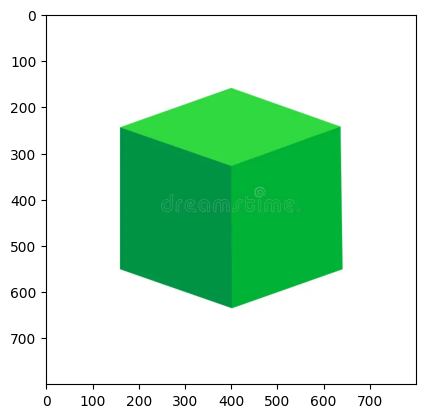

In [ ]:
img_path="/content/drive/MyDrive/is_pro/cirlce.jpg"
predict_shape(img_path)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
